In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.convnext import ConvNeXtXLarge
from keras.layers import Dense, Dropout, Flatten


def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images


def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)

    (train_images, test_images) = normalization(train_images, test_images)

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    # train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    #     buffer_size=10000).batch(batch_size)
    # test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

    return train_images, train_labels, test_images, test_labels


In [2]:
def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
    
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

train_images, train_labels, test_images, test_labels = load_images()

In [3]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
  conv_base = ConvNeXtXLarge(include_top=False, weights='imagenet', input_shape=input_shape)

  if fine_tune > 0:
      for layer in conv_base.layers[:-fine_tune]:
          layer.trainable = False
  else:
      for layer in conv_base.layers:
          layer.trainable = False

  # Create a new 'top' of the model (i.e. fully-connected layers).
  # This is 'bootstrapping' a new top_model onto the pretrained layers.
  top_model = conv_base.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  
  # Group the convolutional base and new fully-connected layers into a Model object.
  model = Model(inputs=conv_base.input, outputs=output_layer)

  training_epochs = 250
  batch_size = 128
  learning_rate = 0.1
  momentum = 0.9
  lr_decay = 1e-6
  lr_drop = 20

  tf.random.set_seed(777)

  optimizer='rmsprop'
  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,    decay=1e-6, momentum=momentum, nesterov=True)
  # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  # model.compile(
  #   optimizer=optimizer,
  #   loss=keras.losses.BinaryCrossentropy(from_logits=True),
  #   metrics=[
  #       keras.metrics.BinaryAccuracy(name="accuracy")
  #   ],
  # )
  return model

In [4]:
model = create_model((32,32,3),10)

In [5]:
training_epochs = 250
batch_size = 128
learning_rate = 0.1
momentum = 0.9
lr_decay = 1e-6
lr_drop = 20

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(x=train_images,
          y=train_labels,
          batch_size=batch_size,
          epochs=30,#n_epochs,
          validation_data=(test_images, test_labels),
          steps_per_epoch=train_images.shape[0] // batch_size,
          validation_steps=test_images.shape[0] // batch_size,
          callbacks=[checkpoint_callback])

Epoch 1/30
390/390 [==============================] - 114s 239ms/step - loss: 1.8488 - accuracy: 0.4130 - val_loss: 1.4802 - val_accuracy: 0.4462
Epoch 2/30
390/390 [==============================] - 91s 227ms/step - loss: 1.3093 - accuracy: 0.5393 - val_loss: 1.3700 - val_accuracy: 0.5254
Epoch 3/30
390/390 [==============================] - 89s 227ms/step - loss: 1.1971 - accuracy: 0.5788 - val_loss: 1.2295 - val_accuracy: 0.5762
Epoch 4/30
390/390 [==============================] - 82s 210ms/step - loss: 1.1161 - accuracy: 0.6070 - val_loss: 1.2691 - val_accuracy: 0.5725
Epoch 5/30
390/390 [==============================] - 89s 227ms/step - loss: 1.0637 - accuracy: 0.6274 - val_loss: 1.1410 - val_accuracy: 0.6123
Epoch 6/30
390/390 [==============================] - 88s 226ms/step - loss: 1.0124 - accuracy: 0.6422 - val_loss: 1.1035 - val_accuracy: 0.6244
Epoch 7/30
390/390 [==============================] - 82s 209ms/step - loss: 0.9700 - accuracy: 0.6573 - val_loss: 1.1437 - val_a

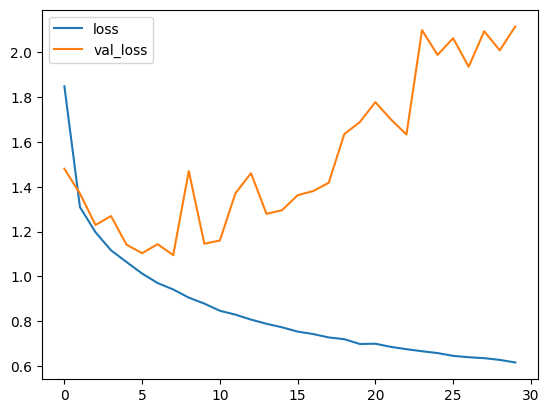

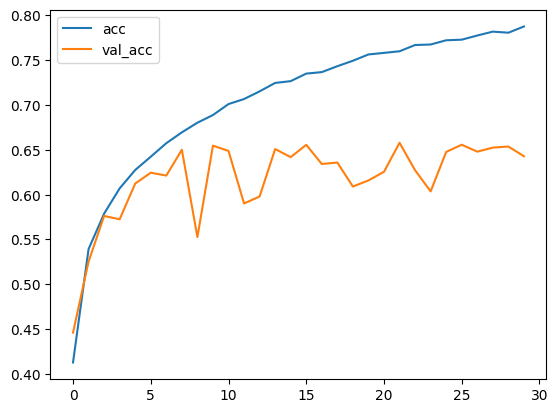

In [6]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()
     


In [7]:
probs = model.predict(test_images)

313/313 [==============================] - 28s 68ms/step


Precisão: 0.6426


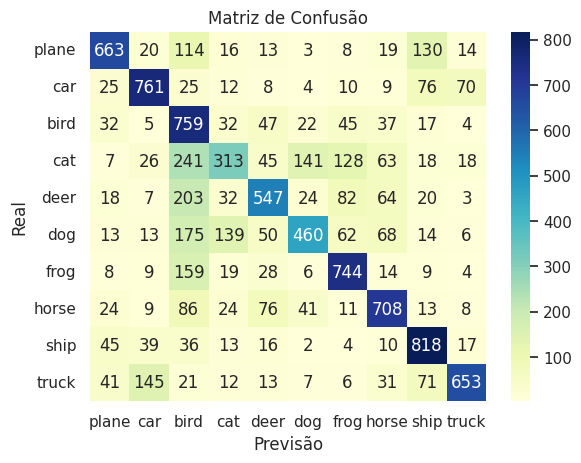

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = np.argmax(test_labels, axis=1)

# Obter os nomes das classes
class_names = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

     
